In [1]:
import pandas as pd
import numpy as np

import os, glob, gzip, pickle

from IPython.display import SVG
from rdkit import Chem, rdBase, RDConfig
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import PandasTools
from rdkit.Chem import AllChem, rdShapeHelpers
from rdkit.Chem.FeatMaps import FeatMaps, FeatMapUtils
from rdkit.Chem.FeatMaps.FeatMapUtils import CombineFeatMaps

import plotly
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [3]:
# Set the default renderer to png as the data is huge and overwhelms the Javascript renderers
pio.renderers.default = 'png'

In [4]:
df_x0072 = PandasTools.LoadSDF('Mpro-x0072_into_x0387.sdf.gz', molColName='Molecule')
print('Shape Mpro-x0072:', df_x0072.shape)
df_x0104 = PandasTools.LoadSDF('Mpro-x0104_into_x0387.sdf.gz', molColName='Molecule')
print('Shape Mpro-x0104:', df_x0104.shape)
df_x0107 = PandasTools.LoadSDF('Mpro-x0107_into_x0387.sdf.gz', molColName='Molecule')
print('Shape Mpro-x0107:', df_x0107.shape)
df_x0387_default = PandasTools.LoadSDF('Mpro-x0387_into_x0387_default_tether.sdf.gz', molColName='Molecule')
print('Shape Mpro-x0387 default:', df_x0387_default.shape)
df_x0387_tight = PandasTools.LoadSDF('Mpro-x0387_into_x0387_tight_tether.sdf.gz', molColName='Molecule')
print('Shape Mpro-x0387 tight:', df_x0387_tight.shape)
df_x0387_free = PandasTools.LoadSDF('Mpro-x0387_into_x0387_free.sdf.gz', molColName='Molecule')
print('Shape Mpro-x0387 free:', df_x0387_free.shape)

Shape Mpro-x0072: (20848, 55)
Shape Mpro-x0104: (23008, 55)
Shape Mpro-x0107: (46337, 55)
Shape Mpro-x0387 default: (11804, 55)
Shape Mpro-x0387 tight: (9056, 55)
Shape Mpro-x0387 free: (32821, 55)


In [5]:
df = df_x0387_default
df.dtypes

CHROM.1                       object
EmbedRMS                      object
Hit                           object
Name                          object
RI                            object
Rbt.Current_Directory         object
Rbt.Executable                object
Rbt.Library                   object
Rbt.Parameter_File            object
Rbt.Receptor                  object
SCORE                         object
SCORE.INTER                   object
SCORE.INTER.CONST             object
SCORE.INTER.POLAR             object
SCORE.INTER.REPUL             object
SCORE.INTER.ROT               object
SCORE.INTER.VDW               object
SCORE.INTER.norm              object
SCORE.INTRA                   object
SCORE.INTRA.DIHEDRAL          object
SCORE.INTRA.DIHEDRAL.0        object
SCORE.INTRA.POLAR             object
SCORE.INTRA.POLAR.0           object
SCORE.INTRA.REPUL             object
SCORE.INTRA.REPUL.0           object
SCORE.INTRA.VDW               object
SCORE.INTRA.VDW.0             object
S

In [6]:
# Drop the columns we don't need and rename some

columns_to_remove = ['CHROM.1', 'RI', 'Rbt.Current_Directory', 'Rbt.Executable', 'Rbt.Library', 
                     'Rbt.Parameter_File', 'Rbt.Receptor', 'Name', 'SCORE.INTER', 'SCORE.INTER.CONST',
                     'SCORE.INTER.POLAR', 'SCORE.INTER.REPUL', 'SCORE.INTER.ROT', 'SCORE.INTER.VDW',
                     'SCORE.INTER.norm', 'SCORE.INTRA', 'SCORE.INTRA.DIHEDRAL', 'SCORE.INTRA.DIHEDRAL.0',
                     'SCORE.INTRA.POLAR', 'SCORE.INTRA.POLAR.0', 'SCORE.INTRA.REPUL', 'SCORE.INTRA.REPUL.0',
                     'SCORE.INTRA.VDW', 'SCORE.INTRA.VDW.0', 'SCORE.INTRA.norm', 'SCORE.RESTR',
                     'SCORE.RESTR.norm', 'SCORE.SYSTEM', 'SCORE.SYSTEM.CONST', 'SCORE.SYSTEM.DIHEDRAL',
                     'SCORE.SYSTEM.norm','SCORE.RESTR.CAVITY','Max_SuCOS_Cluster','Max_SuCOS_Index'
                    ]

columns_to_rename = { 'ID': 'NSMILES'} # NSMILES means Neutral SMILES e.g. prior to charge enumeration

df2 = df.drop(columns=columns_to_remove)
df2 = df2.rename(columns=columns_to_rename)

df2 = df2.astype(dtype= {
    "SuCOS_Score":"float64",
    "SuCOS_FeatureMap_Score":"float64",
    "SuCOS_Protrude_Score":"float64",
    "SCORE":"float64",
    "SCORE.norm":"float64",
    "TransFSScore_10nM":"float64",
    "TransFSScore_50nM":"float64",
    "TransFSScore_200nM":"float64",
    "TransFSScore_1uM":"float64",
    "Max_SuCOS_Score":"float64",
    "Max_SuCOS_FeatureMap_Score":"float64",
    "Max_SuCOS_Protrude_Score":"float64",
    "Cum_SuCOS_Score":"float64",
    "Cum_SuCOS_FeatureMap_Score":"float64",
    "Cum_SuCOS_Protrude_Score":"float64"
})

df2.dtypes

EmbedRMS                       object
Hit                            object
SCORE                         float64
SCORE.heavy                    object
SCORE.norm                    float64
TETHERED ATOMS                 object
SuCOS_Score                   float64
SuCOS_FeatureMap_Score        float64
SuCOS_Protrude_Score          float64
Max_SuCOS_Score               float64
Max_SuCOS_FeatureMap_Score    float64
Max_SuCOS_Protrude_Score      float64
Cum_SuCOS_Score               float64
Cum_SuCOS_FeatureMap_Score    float64
Cum_SuCOS_Protrude_Score      float64
TransFSScore_50nM             float64
TransFSScore_1uM              float64
TransFSScore_10nM             float64
TransFSScore_200nM            float64
NSMILES                        object
Molecule                       object
dtype: object

In [7]:
df2['rotb'] = df2['Molecule'].apply(lambda mol: Chem.rdMolDescriptors.CalcNumRotatableBonds(mol))
df2['hac'] = df2['Molecule'].apply(lambda mol: mol.GetNumHeavyAtoms())

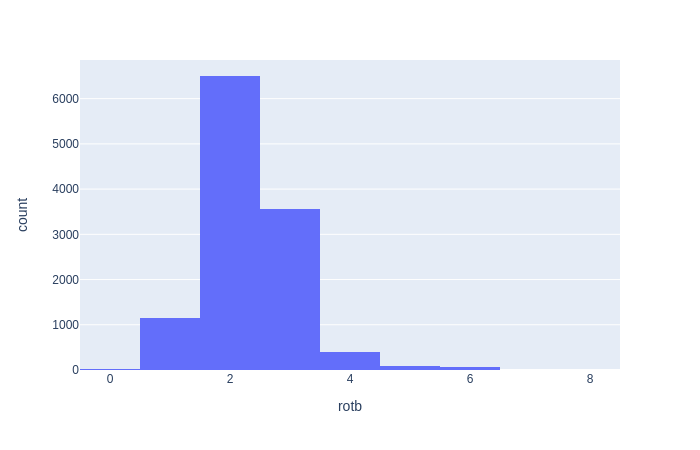

In [8]:
# Let's look at the distribution of scores
fig = px.histogram(df2, x="rotb")
fig.show()

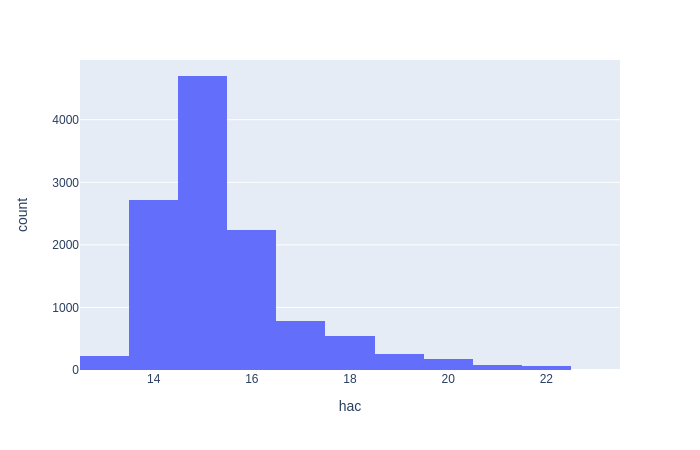

In [9]:
# Let's look at the distribution of HAC
# The Mpro-x0387 hit has 13 heavy atoms
fig = px.histogram(df2, x="hac")
fig.show()

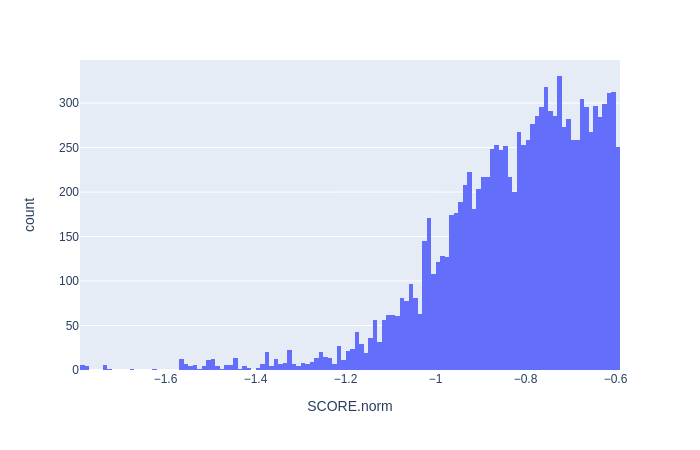

In [10]:
# Let's look at the distribution of scores
fig = px.histogram(df2, x="SCORE.norm")
fig.show()

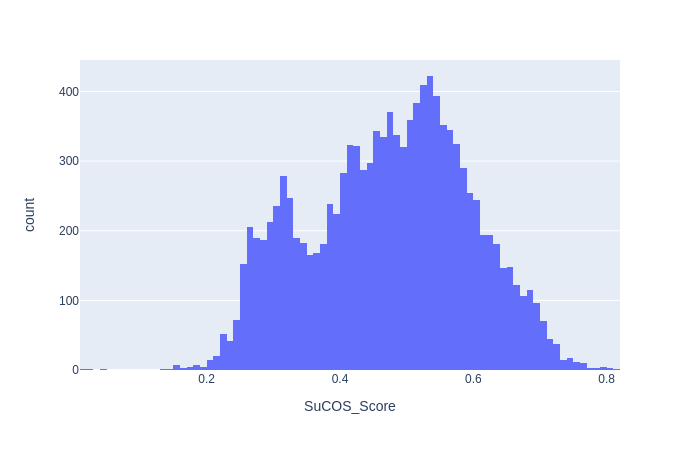

In [11]:
fig = px.histogram(df2, x="SuCOS_Score")
fig.show()

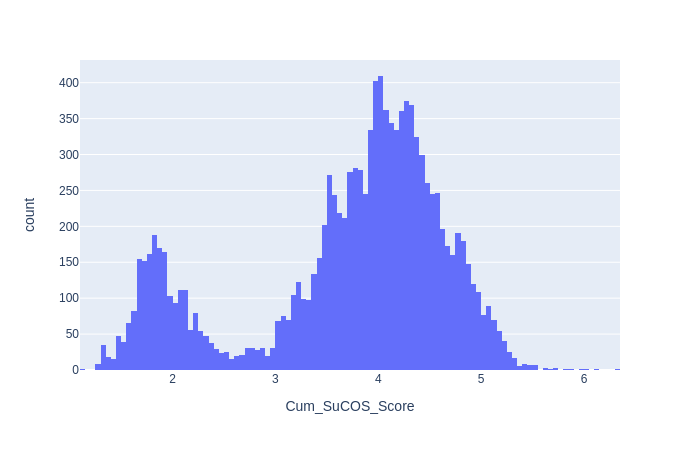

In [12]:
fig = px.histogram(df2, x="Cum_SuCOS_Score")
fig.show()

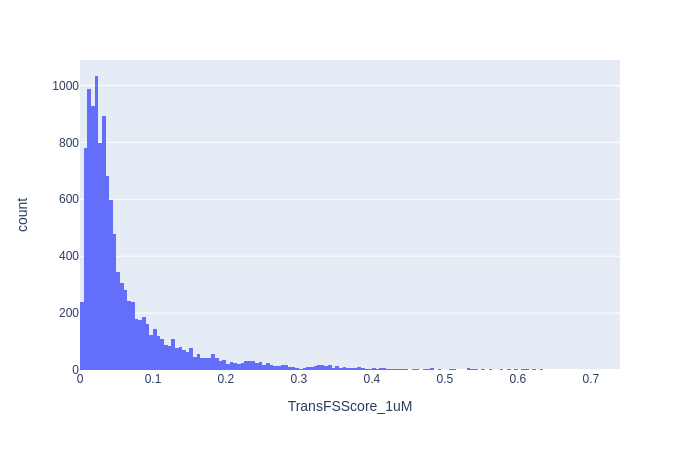

In [13]:
fig = px.histogram(df2, x="TransFSScore_1uM")
fig.show()

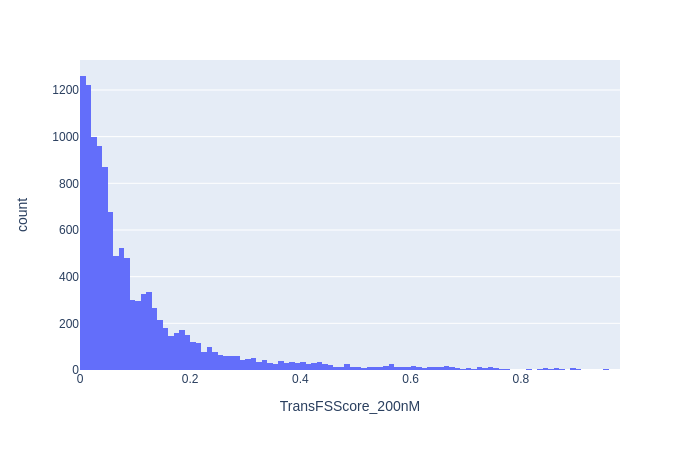

In [14]:
fig = px.histogram(df2, x="TransFSScore_200nM")
fig.show()

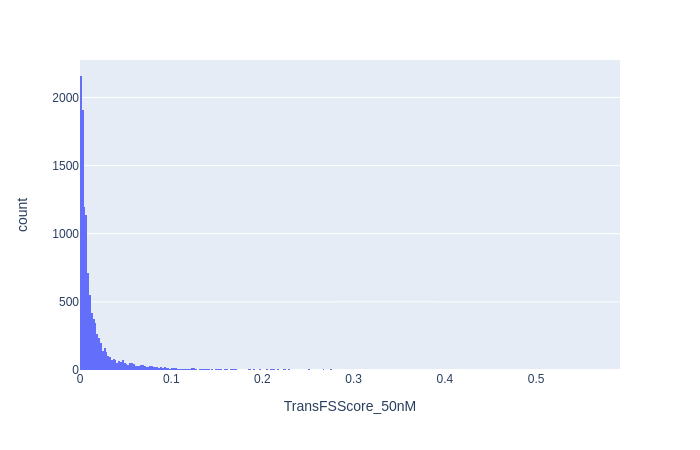

In [15]:
fig = px.histogram(df2, x="TransFSScore_50nM")
fig.show()

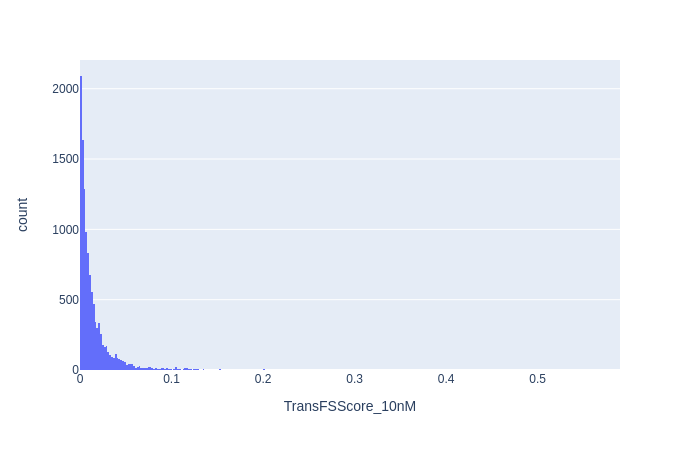

In [16]:
fig = px.histogram(df2, x="TransFSScore_10nM")
fig.show()

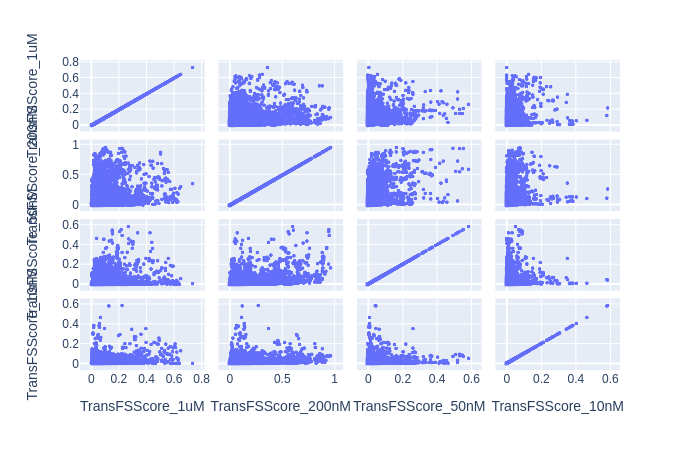

In [17]:
fig = px.scatter_matrix(df2, dimensions=['TransFSScore_1uM','TransFSScore_200nM','TransFSScore_50nM','TransFSScore_10nM'])
fig.update_traces(marker=dict(size=3))
fig.show()

In [18]:
# generate the average of the TransFSScores
df2['TransFSScore'] = (df2['TransFSScore_1uM'] + df2['TransFSScore_200nM'] + df2['TransFSScore_50nM'] + df2['TransFSScore_10nM']) / 4

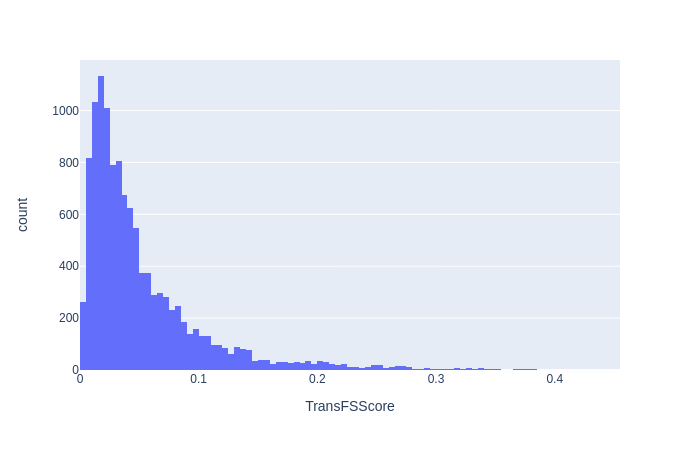

In [19]:
fig = px.histogram(df2, x="TransFSScore")
fig.show()

## SuCOSStein calculations

In [20]:
# read the merged feature map from the saved pickle
fstein = pickle.load( open('../featurestein-22.p', 'rb'))

In [21]:
# This is pretty well exact copy and paste from the SuCOS code in the Squonk Pipelines project:
# https://github.com/InformaticsMatters/pipelines/blob/master/src/python/pipelines/rdkit/sucos.py
# This code needs improving!!!

# Setting up the features to use in FeatureMap
ffact = AllChem.BuildFeatureFactory(os.path.join(RDConfig.RDDataDir, 'BaseFeatures.fdef'))

fmParams = {}
for k in ffact.GetFeatureFamilies():
    fparams = FeatMaps.FeatMapParams()
    fmParams[k] = fparams

keep = ('Donor', 'Acceptor', 'NegIonizable', 'PosIonizable',
        'Aromatic', 'Hydrophobe', 'LumpedHydrophobe')

def filterFeature(f):
    result = f.GetFamily() in keep
    return result

def getRawFeatures(mol):
    rawFeats = ffact.GetFeaturesForMol(mol)
    # filter that list down to only include the ones we're interested in
    filtered = list(filter(filterFeature, rawFeats))
    return filtered

def getFeatureMap(mol):
    feats = getRawFeatures(mol)
    return FeatMaps.FeatMap(feats=feats, weights=[1]*len(feats),params=fmParams)

In [22]:
# now generate the FeatureStein scores
def gen_score(mol):
    featMap = getFeatureMap(mol)
    return featMap.ScoreFeats(fstein.GetFeatures()) / featMap.GetNumFeatures()

df2['FeatureStein'] = df2['Molecule'].apply(gen_score)
df2.dtypes

EmbedRMS                       object
Hit                            object
SCORE                         float64
SCORE.heavy                    object
SCORE.norm                    float64
TETHERED ATOMS                 object
SuCOS_Score                   float64
SuCOS_FeatureMap_Score        float64
SuCOS_Protrude_Score          float64
Max_SuCOS_Score               float64
Max_SuCOS_FeatureMap_Score    float64
Max_SuCOS_Protrude_Score      float64
Cum_SuCOS_Score               float64
Cum_SuCOS_FeatureMap_Score    float64
Cum_SuCOS_Protrude_Score      float64
TransFSScore_50nM             float64
TransFSScore_1uM              float64
TransFSScore_10nM             float64
TransFSScore_200nM            float64
NSMILES                        object
Molecule                       object
rotb                            int64
hac                             int64
TransFSScore                  float64
FeatureStein                  float64
dtype: object

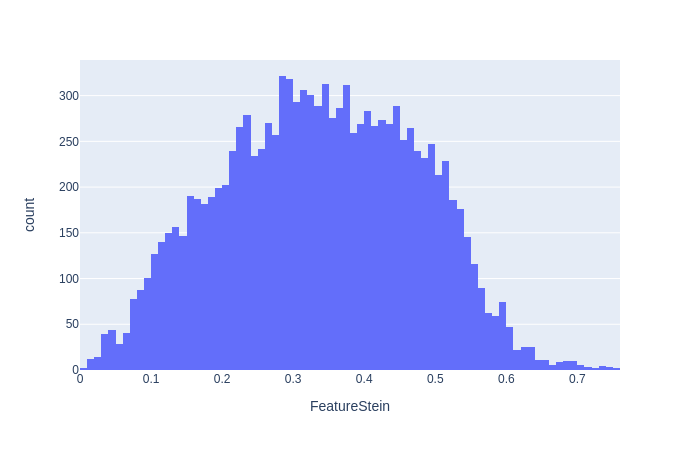

In [23]:
fig = px.histogram(df2, x="FeatureStein")
fig.show()

## Correlation of scores

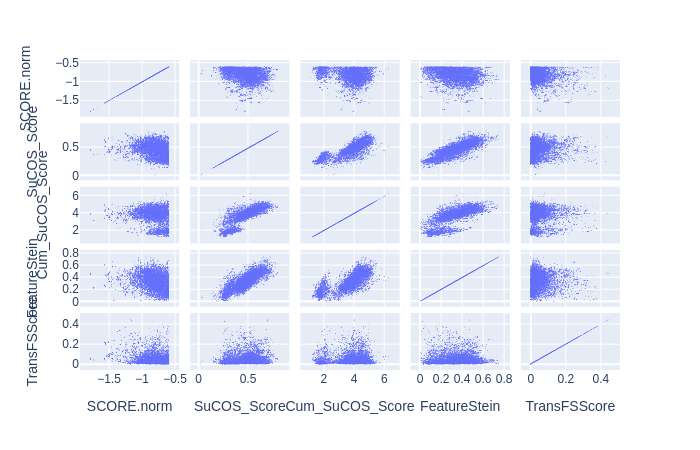

In [24]:
# Compare the average TranFS Score with the normalised docking score and the SuCOS score
fig = px.scatter_matrix(df2, dimensions=['SCORE.norm', 'SuCOS_Score', 'Cum_SuCOS_Score', 'FeatureStein', 'TransFSScore'])
fig.update_traces(marker=dict(size=1))
fig.show()

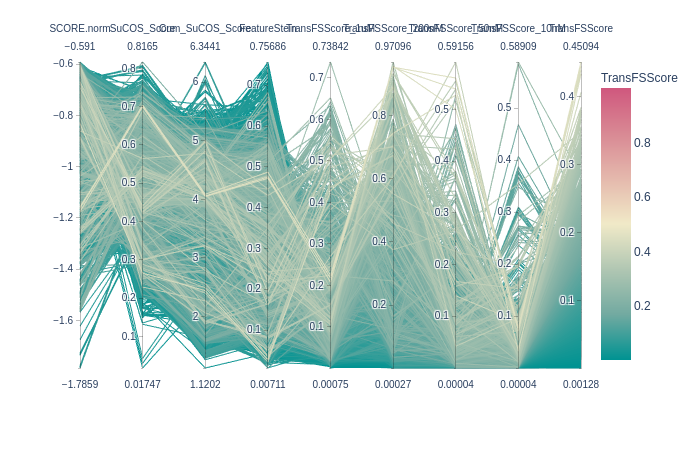

In [25]:
fig = px.parallel_coordinates(df2, color="TransFSScore", 
                dimensions=['SCORE.norm', 'SuCOS_Score', 'Cum_SuCOS_Score', 'FeatureStein', 'TransFSScore_1uM','TransFSScore_200nM','TransFSScore_50nM','TransFSScore_10nM', 'TransFSScore'],              
                color_continuous_scale=px.colors.diverging.Tealrose,
                color_continuous_midpoint=0.5,
                width=1200,
                height=400
            )
fig.show()

In [26]:
# simple filtering by value
df_best = df2[(df2['TransFSScore'] > 0.15) & (df2['FeatureStein'] > 0.4)]
df_best.shape

(256, 25)

In [27]:
# Alternatively select the to n % of TransFS scores
n = 15
df_tfs = df2.sort_values(by='TransFSScore', ascending=False).head(int(len(df2)*(n/100)))
df_tfs.shape

(1770, 25)

In [28]:
# And the top n % of FeatureStein scores
n = 15
df_stein = df2.sort_values(by='FeatureStein', ascending=False).head(int(len(df2)*(n/100)))
df_stein.shape

(1770, 25)

In [29]:
# And find the intersection of the two.
df_top = df2[df2.index.isin(df_tfs.index & df_stein.index)]
df_top.shape

(268, 25)

,EmbedRMS,Hit,SCORE,SCORE.heavy,SCORE.norm,TETHERED ATOMS,SuCOS_Score,SuCOS_FeatureMap_Score,SuCOS_Protrude_Score,Max_SuCOS_Score,...,TransFSScore_50nM,TransFSScore_1uM,TransFSScore_10nM,TransFSScore_200nM,NSMILES,Molecule,rotb,hac,TransFSScore,FeatureStein
1030,0.12058355182299924,Mpro-x0387_0,-14.0216,18,-0.778976,"16,15,14,13,12,2,3,18,17",0.364775,0.151286,0.578264,0.467883,...,0.019673,0.214321,0.013937,0.214474,O=C(CSCc1ccc(Cl)s1)N1CCC(O)CC1,,4,18,0.115601,0.513920
1031,0.12058355182299924,Mpro-x0387_0,-13.9477,18,-0.774870,"16,15,14,13,12,2,3,18,17",0.348695,0.132193,0.565196,0.475190,...,0.015733,0.249122,0.008962,0.270506,O=C(CSCc1ccc(Cl)s1)N1CCC(O)CC1,,4,18,0.136081,0.504294
1383,0.29525448223892053,Mpro-x0387_0,-16.3674,15,-1.091160,"1,2,3,4,5,6,7,14,15",0.596122,0.386303,0.805942,0.596122,...,0.033794,0.056481,0.002821,0.437058,OC1CCN(Cc2ccncc2Cl)CC1,,2,15,0.132539,0.500694
1384,0.29525448223892053,Mpro-x0387_0,-16.3565,15,-1.090440,"1,2,3,4,5,6,7,14,15",0.600829,0.391768,0.809890,0.600829,...,0.033535,0.054845,0.002991,0.424081,OC1CCN(Cc2ccncc2Cl)CC1,,2,15,0.128863,0.506304
1385,0.29525448223892053,Mpro-x0387_0,-16.3323,15,-1.088820,"1,2,3,4,5,6,7,14,15",0.601319,0.392943,0.809695,0.601319,...,0.033111,0.055612,0.002855,0.430740,OC1CCN(Cc2ccncc2Cl)CC1,,2,15,0.130580,0.503685

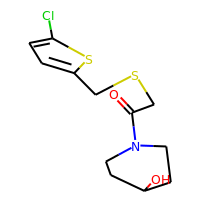
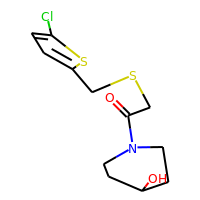
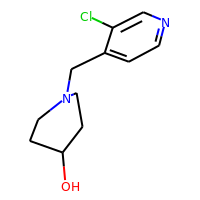
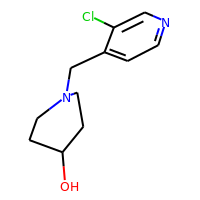
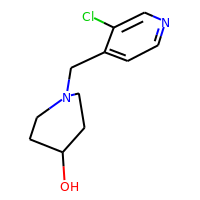

In [30]:
# so these are molecules that have a top TransFS score and a top FeatureStein score 
df_top.head()

In [31]:
# Save dataframe as SDF
PandasTools.WriteSDF(df_top, 'top_mols.sdf', molColName='Molecule', idName='NSMILES', 
                     properties=['TransFSScore', 'FeatureStein','SCORE.norm','Max_SuCOS_Score','Cum_SuCOS_Score','TransFSScore_50nM','TransFSScore_1uM','TransFSScore_10nM','TransFSScore_200nM','TETHERED ATOMS'])
# And as CSV
df_top.to_csv('top_mols.csv', columns=['TransFSScore', 'SuCOS_Score', 'FeatureStein','Max_SuCOS_Score','Cum_SuCOS_Score','SCORE.norm', 'NSMILES'])